<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_merged_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TO DO



*   take care of _x and _y


# Load data

##Loading Files

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from lightgbm import LGBMRegressor, plot_importance
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

In [90]:
url = 'https://www.dati.lombardia.it/api/views/bbky-sde5/rows.csv?accessType=DOWNLOAD'

if os.path.isdir('/tmp'):
    if os.path.isfile('/tmp/cened20.csv'):
      pass
    else:
      urllib.request.urlretrieve(url, '/tmp/cened20.csv')
else:
  os.mkdir('/tmp')
  urllib.request.urlretrieve(url, '/tmp/cened20.csv')

In [91]:
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')

In [92]:
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [270]:
cols20 = ['RIQUALIFICAZIONE_ENERGETICA',
           'ANNO_COSTRUZIONE','SUPERF_UTILE_RISCALDATA', 
           'VOLUME_LORDO_RISCALDATO', 'SUPERFICIE_DISPERDENTE', 'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE', 
           'CLASSIFICAZIONE_DPR', 'COMUNE', 'EP_H_ND','EP_GL_NREN','EP_GL_REN', 
           'NUMERO_UNITA_IMMOBILIARI', 'RISTRUTTURAZIONE_IMPORTANTE', 
           'COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO']

cols12 = ['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'ANNO_COSTRUZIONE','NUMERO_RICAMBI_ORARI', 'EPH']
  
cened20 = pd.read_csv('/tmp/cened20.csv', usecols = cols20)
cened12 = pd.read_csv('/tmp/cened12.csv', usecols = cols12)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [271]:
print(len(cened12))

1516483


In [272]:
print(len(cened20))

939605


## Pre-processing

In [273]:
cened20['EP_GL_NREN'].fillna(0, inplace=True)
cened20['EP_GL_REN'].fillna(0, inplace=True)

# Drop NaN 
cened20 = cened20.dropna()
cened12 = cened12.dropna() 

In [274]:
# Only entire buildings
# cened20 = cened20[cened20['INTERO_EDIFICIO'] == True]

In [275]:
# Drop renovations
cened20 = cened20[cened20['RISTRUTTURAZIONE_IMPORTANTE'] == False]
cened20 = cened20[cened20['RIQUALIFICAZIONE_ENERGETICA'] == False]

In [276]:
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.astype(str)
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened20.ANNO_COSTRUZIONE = cened20.ANNO_COSTRUZIONE.astype(int)

cened20['PERIODO_20'] = pd.cut(cened20.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

In [277]:
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.astype(str)
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened12.ANNO_COSTRUZIONE = cened12.ANNO_COSTRUZIONE.astype(int)

cened12['PERIODO_12'] = pd.cut(cened12.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

## Merge

In [278]:
# Take care of city names
cened12['COMUNE'] = cened12['COMUNE'].str.lower()
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"o`",  "o'")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"baranzate",  "bollate")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened12['COMUNE'] = cened12['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")

cened20['COMUNE'] = cened20['COMUNE'].str.lower()
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"`",  "'")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"o`",  "o'")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"baranzate",  "bollate")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"borgo virgilio",  "virgilio")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r" - ",  "-")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cassina de pecchi",  "cassina de' pecchi")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cerano intelvi",  "cerano d'intelvi")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"colverde",  "drezzo")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"cornale e bastida",  "cornale")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"corteolona e genzone",  "corteolona")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"costa serina",  "costa di serina")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gabbioneta binanuova",  "gabbioneta-binanuova")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gadesco pieve delmona",  "gadesco-pieve delmona")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gerre de'caprioli",  "gerre de' caprioli")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"gravedona ed uniti",  "grandola ed uniti")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"la valletta brianza",  "perego")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"lonato del garda",  "lonato")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"maccagno con pino e veddasca",  "maccagno")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"ramponio vernia",  "ramponio verna")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"sermide e felonica",  "sermide")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"toscolano maderno",  "toscolano-maderno")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"tremezzina",  "tremezzo")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"val brembilla",  "brembilla")
cened20['COMUNE'] = cened20['COMUNE'].str.replace(r"verderio",  "verderio inferiore")

In [279]:
exall12 = cened12['SUBALTERNO'].str.extractall('(\d+)').fillna(0)
cened12 = exall12.join(cened12.reindex(exall12.index, level=0)).reset_index()
cened12['SUBALTERNO'] = cened12[0]

exall20 = cened20['SUBALTERNO'].str.extractall('(\d+)').fillna(0)
cened20 = exall20.join(cened20.reindex(exall20.index, level=0)).reset_index()
cened20['SUBALTERNO'] = cened20[0]

In [280]:
# Merge dfs
cenedtot = pd.merge(left=cened20, right=cened12, left_on=['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO'], #, 'PERIODO' 
                    right_on=['COMUNE','FOGLIO', 'PARTICELLA', 'SUBALTERNO'],  how='inner') # , 'SUBALTERNO' | , 'SUBALTERNO'

In [281]:
print(len(cenedtot))

21426


## Pre-filtering

In [282]:
# Compute difference between ext surfaces
# cenedtot['surfdiff'] = abs((cenedtot['SUPERF_UTILE_RISCALDATA'] - cenedtot['SUPERFICIE_NETTA'])/cenedtot['SUPERF_UTILE_RISCALDATA'])

# Drop rows with high difference
#cenedtot = cenedtot[cenedtot['surfdiff'] < 0.25]

# Compute difference between ext surfaces
#cenedtot['surfdiff'] = abs((cenedtot['SUPERFICIE_DISPERDENTE_y'] - cenedtot['SUPERFICIE_DISPERDENTE_x'])/cenedtot['SUPERFICIE_DISPERDENTE_y'])

# Drop rows with high difference
#cenedtot = cenedtot[cenedtot['surfdiff'] < 0.25]

In [283]:
# Compute difference between EPH
cenedtot['ephdiff'] = abs((cenedtot['EPH'] - cenedtot['EP_H_ND'])/cenedtot['EPH'])

# Drop rows with high difference
cenedtot = cenedtot[cenedtot['ephdiff'] < 0.30]

In [284]:
cenedtot['DESTINAZIONE_DI_USO'] = cenedtot['DESTINAZIONE_DI_USO'].str.replace(r'E.1 (1)', 'E.1(1)')
cenedtot = cenedtot[cenedtot['DESTINAZIONE_DI_USO'] == 'E.1(1)']
# cenedtot = cenedtot[cenedtot['DESTINAZIONE_DI_USO'].str.contains('|'.join(['E.1', 'E.2']))]

In [285]:
cenedtot = cenedtot.dropna() 

In [286]:
cenedtot = cenedtot.drop(['SUBALTERNO', '0_x', 'match_x', 'level_0_x', 'level_0_y',	'match_y',	'0_y'], axis = 1).drop_duplicates()

In [287]:
print(len(cenedtot))

4328


# Preprocessing

In [288]:
cenedtot['SUPERFICIE_DISPERDENTE'] = (cenedtot['SUPERFICIE_DISPERDENTE_x'] + cenedtot['SUPERFICIE_DISPERDENTE_y'])/2

In [289]:
# Correct floats
for col in ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO', 'SUPERFICIE_DISPERDENTE',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE','EP_H_ND','EP_GL_NREN','EP_GL_REN']:
    cenedtot[col] = cenedtot[col].astype(str)
    cenedtot[col] = cenedtot[col].str.replace(r',', '')
    cenedtot[col] = cenedtot[col].astype("float")

In [290]:
# Take care of ach
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.astype(str)
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.map(lambda x:x[:6])
cenedtot.NUMERO_RICAMBI_ORARI = cenedtot.NUMERO_RICAMBI_ORARI.astype(float)

#Feature engineering

In [291]:
# Add ddh
ddh['comune'] = ddh['comune'].str.lower()
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cenedtot = cenedtot.merge(ddh, left_on='COMUNE', right_on='comune', how='left')

In [292]:
# Opaque surface
cenedtot['SUP_OPACA'] = cenedtot['SUPERFICIE_DISPERDENTE']/(1+cenedtot['SUPERFICIE_VETRATA_OPACA'])

# Glazing
cenedtot['SUP_FINESTRATA'] = cenedtot['SUPERFICIE_DISPERDENTE'] - cenedtot['SUP_OPACA']

In [293]:
cenedtot['ALTEZZA_MEDIA_12'] = cenedtot['VOLUME_NETTO']/cenedtot['SUPERFICIE_NETTA']
cenedtot['ALTEZZA_MEDIA_20'] = cenedtot['VOLUME_LORDO_RISCALDATO']/cenedtot['SUPERF_UTILE_RISCALDATA']

In [294]:
cenedtot['TRASMITTANZA_MEDIA'] = (cenedtot['TRASMITTANZA_MEDIA_SERRAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_COPERTURA'] +
         cenedtot['TRASMITTANZA_MEDIA_BASAMENTO'] + cenedtot['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

In [295]:
cenedtot['EP_GL_TOT'] = cenedtot['EP_GL_REN'] + cenedtot['EP_GL_NREN']

In [296]:
# East facing surface
cenedtot['A_SOL_EST'] = cenedtot['A_SOL_EST_A_SUP_UTILE']*cenedtot['SUPERF_UTILE_RISCALDATA']

#Filters

In [297]:
for col in ['TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO']:
          cenedtot = cenedtot[cenedtot[col].between(0,6, inclusive=False)]

cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] > 0.15]
cenedtot = cenedtot[cenedtot['TRASMITTANZA_MEDIA'] < 4]

cenedtot = cenedtot[cenedtot['Y_IE'] <= 6]
cenedtot = cenedtot[cenedtot['Y_IE'] >= 0.01]

In [298]:
# Drop buildings with wrong An
cenedtot = cenedtot[cenedtot['SUPERFICIE_NETTA'] >= 50]
cenedtot = cenedtot[cenedtot['SUPERF_UTILE_RISCALDATA'] >= 50]

# Drop buildings with wrong Vn
cenedtot = cenedtot[cenedtot['VOLUME_NETTO'] > 150]
cenedtot = cenedtot[cenedtot['VOLUME_LORDO_RISCALDATO'] >= 150]

In [299]:
# Glazed surface
cenedtot = cenedtot[cenedtot['SUP_FINESTRATA'] > 1]

# Glazing ratio
cenedtot = cenedtot[cenedtot['SUPERFICIE_VETRATA_OPACA'] > 0]
cenedtot = cenedtot[cenedtot['SUPERFICIE_VETRATA_OPACA'] < 0.9]

In [300]:
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA_12'] > 2.4]
cenedtot = cenedtot[cenedtot['ALTEZZA_MEDIA_20'] > 2.4]

In [301]:
# Drop buildings with wrong EPH
cenedtot = cenedtot[cenedtot['EP_H_ND'] > 5]
cenedtot = cenedtot[cenedtot['EP_H_ND'] < 1000]

In [302]:
cenedtot = cenedtot[cenedtot['A_SOL_EST_A_SUP_UTILE'] <= 0.5]
cenedtot = cenedtot[cenedtot['A_SOL_EST_A_SUP_UTILE'] > 0]

In [303]:
len(cenedtot)

2949

# Data analysis

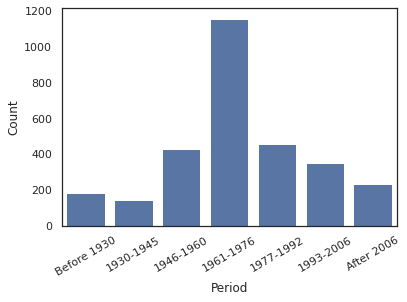

In [304]:
# Period
fig = plt.figure(figsize = (6,4))
cplot = sns.countplot(x = pd.cut(cenedtot.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

# Shuffle

In [305]:
cened = cenedtot.sample(frac=1, random_state = 42).reset_index(drop=True)

# Reserve a test set

In [306]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [307]:
print(len(train))

2356


In [308]:
print(len(test))

593


# Define MAPE

In [309]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [310]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [311]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [312]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# 2.0 inputs

## Random search

In [338]:
mlcol = ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO',
           'SUPERFICIE_DISPERDENTE_x', 'dd','PERIODO_20',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE',
           'ALTEZZA_MEDIA_20', 'A_SOL_EST', 'NUMERO_UNITA_IMMOBILIARI']

In [339]:
cat_feats = ['PERIODO_20']

In [340]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE <100%')

random_search.fit(cened[mlcol], cened['EP_H_ND'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   57.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  2.7min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO_20']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9062f71278>,
            

## Print results

In [341]:
print(random_search.best_params_)

{'bagging_fraction': 1.0, 'bagging_freq': 8, 'feature_fraction': 0.5, 'lambda_l1': 0.37547244535500607, 'lambda_l2': 0.5097781550969235, 'max_bin': 200, 'max_depth': -1, 'num_leaf': 38}


In [342]:
print(random_search.best_score_)

-0.2035455600993857


In [343]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_MAPE         -0.241476
split1_test_MAPE         -0.246305
split2_test_MAPE         -0.273212
split3_test_MAPE         -0.240815
split4_test_MAPE         -0.252357
split0_test_MAPE <100%   -0.213006
split1_test_MAPE <100%   -0.207374
split2_test_MAPE <100%   -0.212611
split3_test_MAPE <100%   -0.197723
split4_test_MAPE <100%   -0.200467
split0_test_R2            0.568314
split1_test_R2            0.625117
split2_test_R2            0.604511
split3_test_R2            0.654062
split4_test_R2             0.65812
Name: 0, dtype: object


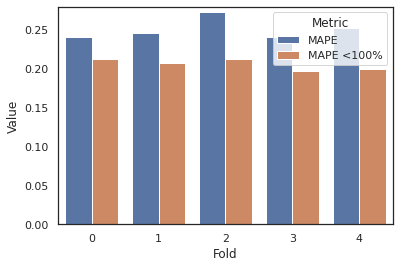

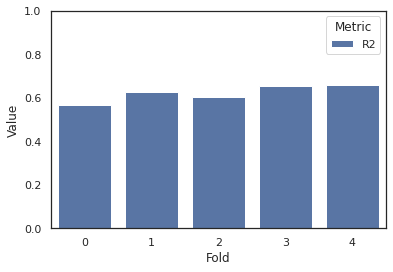

In [347]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
ax.set(ylim = (0, 0.28))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

## Train the final model

In [360]:
light = LGBMRegressor(n_estimators = 10000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=8, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', is_training_metric=True,
              lambda_l1=0.37547244535500607, lambda_l2=0.5097781550969235,
              learning_rate=0.1, max_bin=200, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=6, num_leaf=38, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=False, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=2)

In [361]:
light.fit(train[mlcol], train['EP_H_ND'])

LGBMRegressor(bagging_fraction=1.0, bagging_freq=8, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', is_training_metric=True,
              lambda_l1=0.37547244535500607, lambda_l2=0.5097781550969235,
              learning_rate=0.1, max_bin=200, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=6, num_leaf=38, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=False, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0, verbose=2)

## Test the model

In [362]:
y_pred = light.predict(test[mlcol]).clip(0)

In [363]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['EP_H_ND']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [364]:
# MAPE
results_df['error'].mean()

25.810991836252445

In [365]:
# Max % error
results_df['error'].max()

403.763683074418

In [366]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

predicted    101.306877
true          20.110000
error        403.763683
Name: 2230, dtype: float64

In [367]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

21.260681939069883

In [368]:
# R2 
print(r2_score(test['EP_H_ND'], y_pred))

0.6552373361361901


In [369]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

0.6491904913499701


In [370]:
results_df

,predicted,true,error
9,110.517307,110.45,0.060939
10,168.952884,125.34,34.795663
13,259.138941,214.66,20.720647
22,204.098535,219.45,6.995427
26,158.838914,214.11,25.814341
...,...,...,...
2919,165.228638,165.19,0.023390
2933,146.651313,179.98,18.517995
2940,121.015996,167.47,27.738702
2941,157.112951,209.61,25.045107


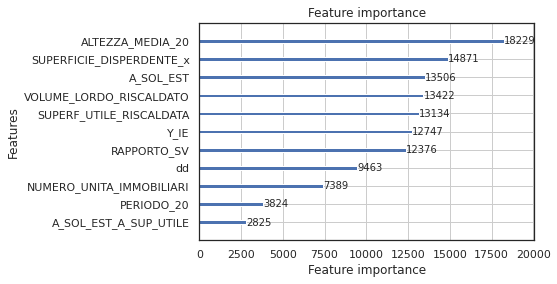

In [371]:
plot_importance(light)

## Error analysis

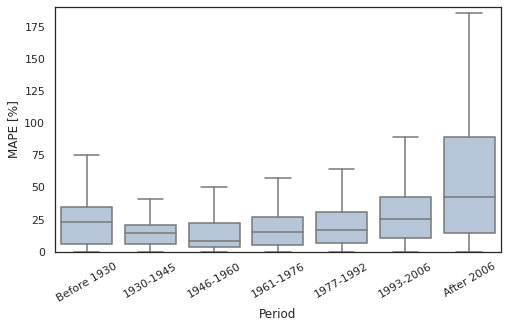

In [382]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (8, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 190), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

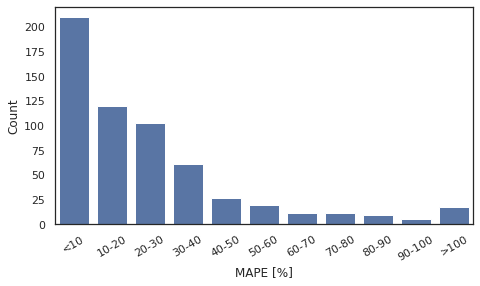

In [383]:
# Error
fig = plt.figure(figsize = (7.5,4))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

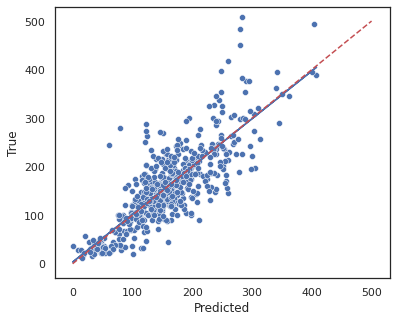

In [384]:
# Scatterplot
fig = plt.figure(figsize = (6,5))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 530), ylim=(-30, 530))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 500], [0,500], c = 'r', linestyle='--')
plt.show()

# 1.2 inputs

## Random search

In [385]:
mlcol = ['PERIODO_20', 'SUPERFICIE_LORDA', 'SUPERFICIE_NETTA',
           'VOLUME_LORDO', 
         'VOLUME_NETTO', 'SUPERFICIE_DISPERDENTE_x',
         'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
         'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO',
         'dd','SUP_FINESTRATA','SUP_OPACA', 'SUPERFICIE_VETRATA_OPACA',
         'NUMERO_RICAMBI_ORARI', 'ALTEZZA_MEDIA_12'] # 'SUPERF_UTILE_RISCALDATA', 'VOLUME_LORDO_RISCALDATO', 

In [386]:
cat_feats = ['PERIODO_20']

In [387]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE <100%')

random_search.fit(cened[mlcol], cened['EP_H_ND'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   14.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed:  4.6min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO_20']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9065d92908>,
            

## Print results

In [388]:
print(random_search.best_params_)

{'bagging_fraction': 0.8615384615384616, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.5320024208474458, 'lambda_l2': 0.11700873856306705, 'max_bin': 1000, 'max_depth': -1, 'num_leaf': 26}


In [389]:
print(random_search.best_score_)

-0.18136997994275156


In [390]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_MAPE         -0.173504
split1_test_MAPE         -0.181979
split2_test_MAPE          -0.19014
split3_test_MAPE         -0.191057
split4_test_MAPE         -0.204249
split0_test_MAPE <100%   -0.168721
split1_test_MAPE <100%   -0.178248
split2_test_MAPE <100%   -0.186015
split3_test_MAPE <100%   -0.189582
split4_test_MAPE <100%   -0.184936
split0_test_R2            0.721417
split1_test_R2            0.754747
split2_test_R2            0.735045
split3_test_R2            0.712493
split4_test_R2            0.766293
Name: 0, dtype: object


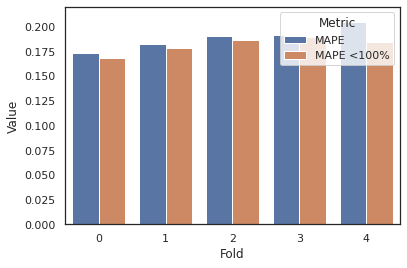

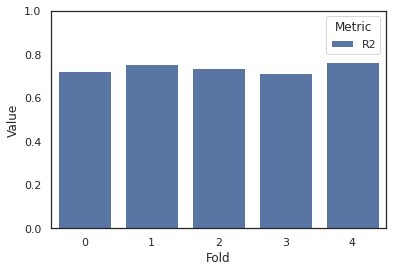

In [391]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
ax.set(ylim = (0, 0.22))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

## Train the final model

In [392]:
light = LGBMRegressor(n_estimators = 10000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=0.8615384615384616, bagging_freq=2,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.5, importance_type='split',
              is_training_metric=True, lambda_l1=0.5320024208474458,
              lambda_l2=0.11700873856306705, learning_rate=0.1, max_bin=1000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=6, num_leaf=26,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [393]:
light.fit(train[mlcol], train['EP_H_ND'])

LGBMRegressor(bagging_fraction=0.8615384615384616, bagging_freq=2,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.5, importance_type='split',
              is_training_metric=True, lambda_l1=0.5320024208474458,
              lambda_l2=0.11700873856306705, learning_rate=0.1, max_bin=1000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=6, num_leaf=26,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

## Test the model

In [394]:
y_pred = light.predict(test[mlcol]).clip(0)

In [395]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['EP_H_ND']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [396]:
# MAPE
results_df['error'].mean()

18.658316943191473

In [397]:
# Max % error
results_df['error'].max()

109.11978759188446

In [398]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

predicted     45.378994
true          21.700000
error        109.119788
Name: 1066, dtype: float64

In [399]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

18.20431939583593

In [400]:
# R2 
print(r2_score(test['EP_H_ND'], y_pred))

0.7734932497111742


In [401]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

0.7715362815168368


In [402]:
results_df

,predicted,true,error
9,149.760981,110.45,35.591654
10,166.833838,125.34,33.105025
13,177.561995,214.66,17.282216
22,180.049251,219.45,17.954317
26,189.897702,214.11,11.308345
...,...,...,...
2919,146.848633,165.19,11.103194
2933,156.619245,179.98,12.979639
2940,117.707712,167.47,29.714150
2941,120.445231,209.61,42.538414


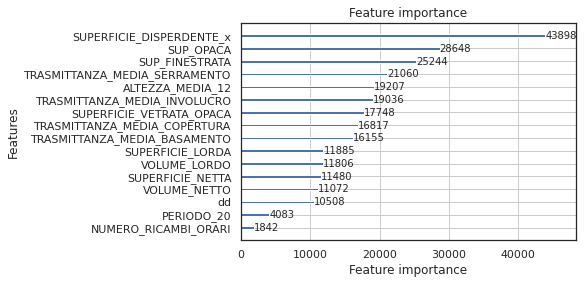

In [403]:
plot_importance(light)

## Error analysis

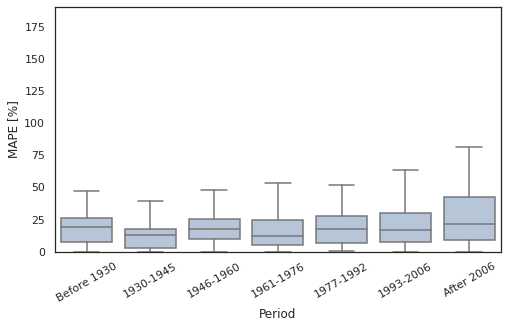

In [404]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE_x, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (8, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 190), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

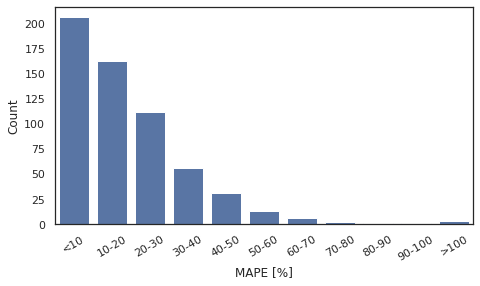

In [405]:
# Error
fig = plt.figure(figsize = (7.5,4))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

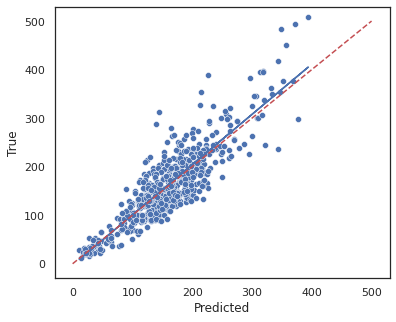

In [406]:
# Scatterplot
fig = plt.figure(figsize = (6,5))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 530), ylim=(-30, 530))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 500], [0,500], c = 'r', linestyle='--')
plt.show()